In [ ]:
# Modèle basé sur un échentillon des 10 espèces les plus représentées.
# L'objectif est d'observer la qualité d'entrainement d'un modèle sur un echantillon réduit.
# La vitesse d'entrainnement du modèle permet d'ajuster facilement les paramètres et les callbacks.

# Lib

In [1]:
import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
#import cv2
%matplotlib inline



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



# Fonctions

In [41]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon):
    '''Importe le fichier csv et construit 4 df :
        - df reprenant l'ensemble des données
        - df_ech est un echantillon de df
        - top10 ne reprend que les 10 labels les plus vus dans df
        - top10_ech est un echantillon de top10
        '''

    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")




    return df, df_ech

In [60]:
from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.preprocessing.image import load_img, img_to_array

def augment_img(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - tf.math.reduce_min(img)) / (tf.math.reduce_max(img) - tf.math.reduce_min(img))
    #img = tf.image.random_rotation(img)
    #img = tf.image.random_crop(img)

    return img, label

In [29]:
def create_tf_dataset(image_path, labels, batch_size):
    image_path = image_path.tolist()  # Convertir les chemins d'images en liste
    labels = labels.tolist()  # Convertir les labels en liste
    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))
    dataset = dataset.map(augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_path))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [30]:
import os
def controle_presence_fichiers(df, chemin_images):


    image_directory = chemin_images
    missing_files = []

# Parcourir chaque ligne du DataFrame
    for index, row in df.iterrows():
        image_path = os.path.join(image_directory, row['image_lien'])
    
        if not os.path.exists(image_path):
            missing_files.append(image_path)

    # Afficher les fichiers non trouvés
    if missing_files:
        print("\nFichiers non trouvés :")
        for file_path in missing_files:
            print(file_path)
    else:
        print("\nTous les fichiers sont présents.")

# Callbacks

In [31]:
from tensorflow.keras import callbacks
%load_ext tensorboard
log_dir = '/'
tensorboard = callbacks.TensorBoard(log_dir = log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.01,
                               patience = 3,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
earlystop = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 3,
                        factor = 0.15, 
                        cooldown = 3,
                        verbose = 1)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='../model/model_ech', monitor='val_accuracy', save_best_only=True, verbose=1)

In [35]:
from tensorflow.keras.callbacks import LearningRateScheduler
# Définition de la fonction pour ajuster le taux d'apprentissage
def lr_schedule(epoch):
    """
    Fonction pour ajuster le taux d'apprentissage en fonction de l'époque.
    """
    learning_rate = 0.1
    if epoch > 15:
        learning_rate = 0.01
    if epoch > 40:
        learning_rate = 0.001
    return learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [36]:
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [37]:
from tensorflow.keras.callbacks import TerminateOnNaN
TON = TerminateOnNaN()

# Données

In [53]:
chemin_images = '../../images/'
chemin_csv = '../data/top10.csv'
pourcentage_echantillon = 0.1 # Si 0.1 : 10% du contenu


df, df_ech = import_df(chemin_images, chemin_csv, pourcentage_echantillon)

Nombre d'images chargées pour df: 64372
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6437
Nb especes dans df_ech: 10


C:\Users\guill\AppData\Local\Temp\ipykernel_3544\1086476059.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)


In [54]:
df.head()

,label,image_lien,image_url
0,Agaricales,486562.jpg,../../images/486562.jpg
1,Agaricales,509189.jpg,../../images/509189.jpg
2,Agaricales,486561.jpg,../../images/486561.jpg
3,Agaricales,231418.jpg,../../images/231418.jpg
4,Agaricales,508881.jpg,../../images/508881.jpg


In [55]:
controle_presence_fichiers(df, chemin_images)
df.drop('image_lien', axis=1, inplace=True)
df_ech.drop('image_lien', axis=1, inplace=True)



Tous les fichiers sont présents.


# Modèle

In [67]:
from tensorflow.keras import layers, models

efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2'
efficientNet = hub.KerasLayer(efficientnet_url, trainable=False)


# Créer le modèle EfficientNet sans les couches de classification
input_layer = layers.Input(shape=(224, 224, 3))
x = efficientNet(input_layer)
efficientNet = models.Model(inputs=input_layer, outputs=x)



# Créer le modèle CNN
model = models.Sequential()
model.add(efficientNet)

# Couche entièrement connectée
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes de sortie

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 1000)              7200312   
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                64064     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 7266786 (27.72 MB)
Trainable params: 66474 (259.66 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


## Jeux train, test & val

In [58]:
data_ech = df_ech.drop('label', axis=1)
target_ech = df_ech['label']

s = LabelEncoder()
target_ech = s.fit_transform(target_ech)


X_train_ech, X_temp_ech, y_train_ech, y_temp_ech = train_test_split(data_ech, target_ech, test_size=0.25, random_state=10)
X_val_ech, X_test_ech, y_val_ech, y_test_ech = train_test_split(X_temp_ech, y_temp_ech, test_size=0.5, random_state=10)

## Datasets

In [61]:
batch_size = 32
ds_train_ech = create_tf_dataset(X_train_ech.image_url, y_train_ech, batch_size)
ds_test_ech = create_tf_dataset(X_test_ech.image_url, y_test_ech, batch_size)
ds_val_ech = create_tf_dataset(X_val_ech.image_url, y_val_ech, batch_size)

## Fit

In [68]:
steps_per_epoch = X_train_ech.shape[0] // batch_size


history_ech = model.fit(ds_train_ech,
                        validation_data = ds_val_ech,
                        epochs=30,
                        callbacks = [tensorboard, early_stopping, earlystop, checkpoint, lr_scheduler, time_callback, TON],
                        verbose=True)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/30
151/151 [==============================] - ETA: 0s - loss: 3.8249 - accuracy: 0.1736
Epoch 1: val_accuracy did not improve from 0.30125
151/151 [==============================] - 152s 958ms/step - loss: 3.8249 - accuracy: 0.1736 - val_loss: 2.2760 - val_accuracy: 0.1627 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.1.
Epoch 2/30
151/151 [==============================] - ETA: 0s - loss: 2.2634 - accuracy: 0.1792
Epoch 2: val_accuracy did not improve from 0.30125
151/151 [==============================] - 152s 986ms/step - loss: 2.2634 - accuracy: 0.1792 - val_loss: 2.3176 - val_accuracy: 0.1627 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.1.
Epoch 3/30
151/151 [==============================] - ETA: 0s - loss: 2.2610 - accuracy: 0.1836
Epoch 3: val_accuracy did not improve from 0.30125
151/151 [==============================] - 148s 965ms/step - loss: 2.2610 - a

## Evaluation

In [69]:
%reload_ext tensorboard
test_loss_ech, test_accuracy_ech = model.evaluate(ds_test_ech)
print("Test accuracy:", test_accuracy_ech)

26/26 [==============================] - 19s 709ms/step - loss: 2.2528 - accuracy: 0.1938
Test accuracy: 0.1937888264656067


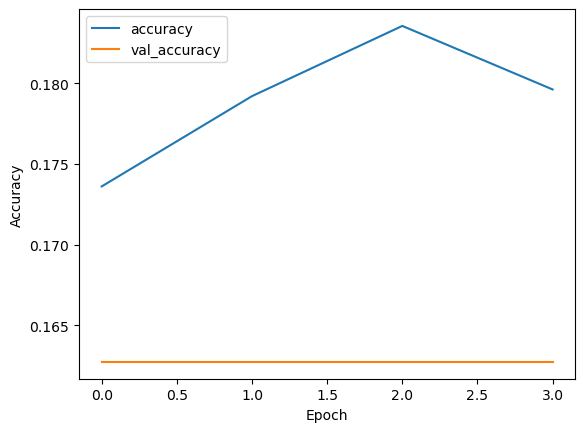

In [70]:
import matplotlib.pyplot as plt

plt.plot(history_ech.history['accuracy'], label='accuracy')
plt.plot(history_ech.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Interprétabilité (Grad Cam)

In [ ]:
# To do

## Sauvegarde modèle

In [ ]:
model.save('./model/modele_echantillon')